# Interface gap-filling code to MBHB code

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [29]:
# import data
fname = '../../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)

In [30]:
# define function to print all attributes of hdf5 file recursively 
# from the LDC quicklook notebooks
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")
# print all dataset attributes (useful to see what's inside the HDF5 file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
gal
    gal/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LIS

### 1.2. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

The import function `load_tdi_timeseries` also builds the missing TDI dataset:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [31]:
# Print the tdi dataset object
print(fid['obs/tdi'])

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">


In [32]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

Let's load all datasets as numpy-recarray objects in a single dictionary `tdi`:

In [33]:
tdi = load_tdi_timeseries(fname = fname)

Let's take a look at the `'obs'` dataset:

In [34]:
tdi['obs']['X']

array([-1.20843503e-21,  4.66545351e-22,  2.48226674e-21, ...,
       -9.29828606e-21,  5.70021014e-21, -4.30521175e-21])

In [35]:
# dataset is a numpy.recarray object with the length of the data time-series and fields ['t','X','Y','Z']
print(tdi['obs'])
print(tdi['obs'].dtype)

[( 8899200., -1.20843503e-21,  1.03963281e-21, -3.83668942e-21)
 ( 8899205.,  4.66545351e-22, -1.35315602e-21,  7.09159015e-21)
 ( 8899210.,  2.48226674e-21, -1.04844445e-21,  1.09270023e-21) ...
 (11577585., -9.29828606e-21, -6.92159820e-21,  7.19464761e-21)
 (11577590.,  5.70021014e-21, -9.60595940e-22, -4.94114626e-21)
 (11577595., -4.30521175e-21,  8.29780973e-21,  2.00536395e-20)]
[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


Set up dataset constant values:

In [36]:
# number of samples to skip at the beginning of the file
skip = 100 
# length of time-series
ndata = len(tdi['obs'][skip:])
# time step
dt = tdi['obs']['t'][1]-tdi['obs']['t'][0]
# sampling frequency
fs = 1.0/dt
t_obs = ndata / fs

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


## 2. Build orthogonal TDI combinations

We can proceed in two different ways to build orthogonal TDI combinations for all the datasets of our interest, i.e. `n+s`, `s`, `n`, `n+s+g` `n+g` data, according to our needs.

1. We can create separate numpy rec-arrays, one for each separate dataset
2. We can create a dictionary containing orthogonal TDI combinations for all imported datasets them


Each of these can then be wired into the Spritz analysis.

In [37]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [38]:
# option 1 - separate numpy rec-arrays
td_data = build_orthogonal_tdi(tdi['obs'])
td_datans = build_orthogonal_tdi(tdi['clean'])
td_datas  = build_orthogonal_tdi(tdi['sky'])
td_datan  = build_orthogonal_tdi(tdi['noise'])
td_datag  = build_orthogonal_tdi(tdi['clean_gapped'])
td_datang = build_orthogonal_tdi(tdi['noise_gapped'])

print(td_datans.dtype.names)

# # option 2 - single dictionary containing all numpy recarrays
# data = build_orthogonal_tdi(tdi)
# print(data.keys())
# print(data['obs'].dtype.names)

('t', 'A', 'E', 'T')


(11500000.0, 11570000.0)

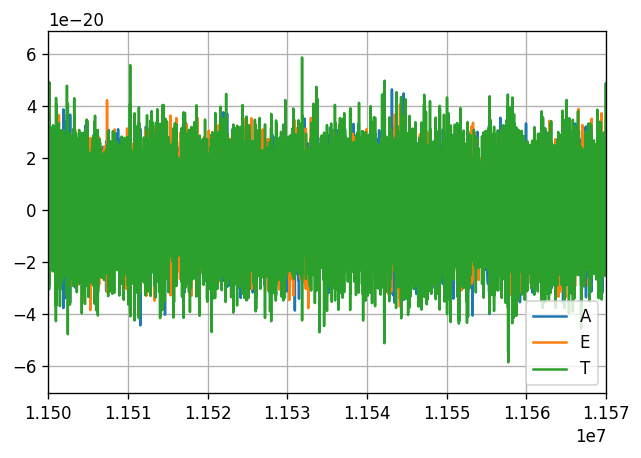

In [39]:
fig, ax = plt.subplots(1,1, dpi=120)
ax.plot(td_datan['t'], td_datan['A'], label='A')
ax.plot(td_datan['t'], td_datan['E'], label='E')
ax.plot(td_datan['t'], td_datan['T'], label='T')
ax.legend()
ax.grid()
ax.set_xlim([1.15e7,1.157e7])

## 3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

In [40]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

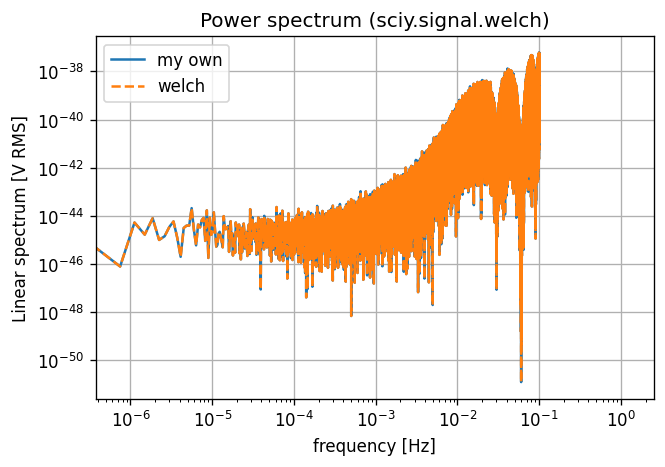

In [41]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(td_datan, chan = 'A', plot = True)

In [42]:
# generate data in the right format for the MBHB search code
# split needs to be set to True

# noise data
datan, psddatan, scalefacn = generate_freq_data(td_datan, split=True, win='blackmanharris')
# noise + signal data
datans, psddatans, scalefacns = generate_freq_data(td_datans, split=True, win='blackmanharris')
# signal data
data, psddata, scalefac = generate_freq_data(td_datas, split=True, win='blackmanharris')

In [43]:
for param, val in zip(fid['sky/cat'].attrs.keys(),fid['sky/cat'][()]):
    print(param, ':', val)

CoalescenceTime : -0.30300442294174235
Distance : 1.2925183861048521
EclipticLatitude : 1.2031361791056812
EclipticLongitude : 2.097303543065685
Inclination : 0.747377
InitialAzimuthalAngleL : 0.8388
InitialPolarAngleL : 1323277.47932
Mass1 : 612485.5060299999
Mass2 : 11526944.921879262
PhaseAtCoalescence : 1.2201968860015653
PolarAngleOfSpin1 : 2.6919824500032945
PolarAngleOfSpin2 : 1.808398497592109
Polarization : 1.73941
Redshift : 13470.983558972537
Spin1 : 31558149.763545603
Spin2 : 3.0


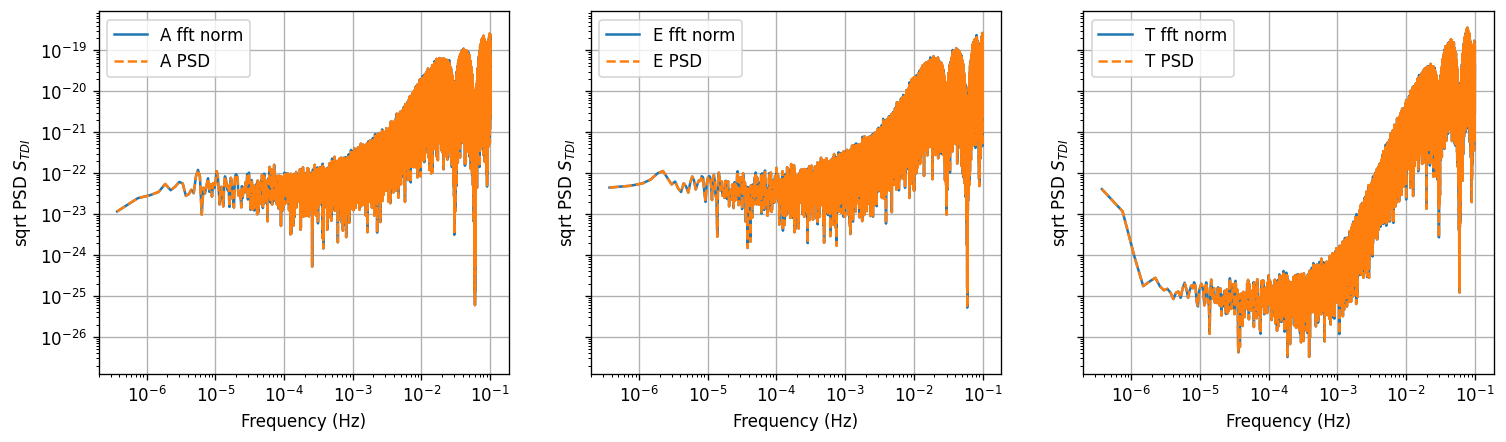

In [44]:
# plot data
fig, ax = plt.subplots(1,3,figsize=(15,4),dpi=120, sharey=True)
ax[0].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,1]+1j*datan[:,2]))), label='A fft norm')
ax[1].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,3]+1j*datan[:,4]))), label='E fft norm')
ax[2].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,5]+1j*datan[:,6]))), label='T fft norm')

ax[0].loglog(psddatan[:,0], np.sqrt(psddatan[:,1]), ls='--', label='A PSD')
ax[1].loglog(psddatan[:,0], np.sqrt(psddatan[:,2]), ls='--', label='E PSD')
ax[2].loglog(psddatan[:,0], np.sqrt(psddatan[:,3]), ls='--', label='T PSD')

for i in range(3):
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel(r'sqrt PSD $S_{TDI}$')
    ax[i].legend()
    ax[i].grid()                                                

For comparing spectra, and compare data with noise models.

Here we compare the three data realizations (noise, signal and noise + signal) and evaluate the gaussianity of the noise realization.

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data deviate significantly from the Gaussian behavior for A and E, but not as much for T.

In [54]:
from bayesdawn.connect.fillgaps import plot_compare_spectra_timeseries
from bayesdawn.connect.lisabeta_fill_gaps import plot_compare_spectra

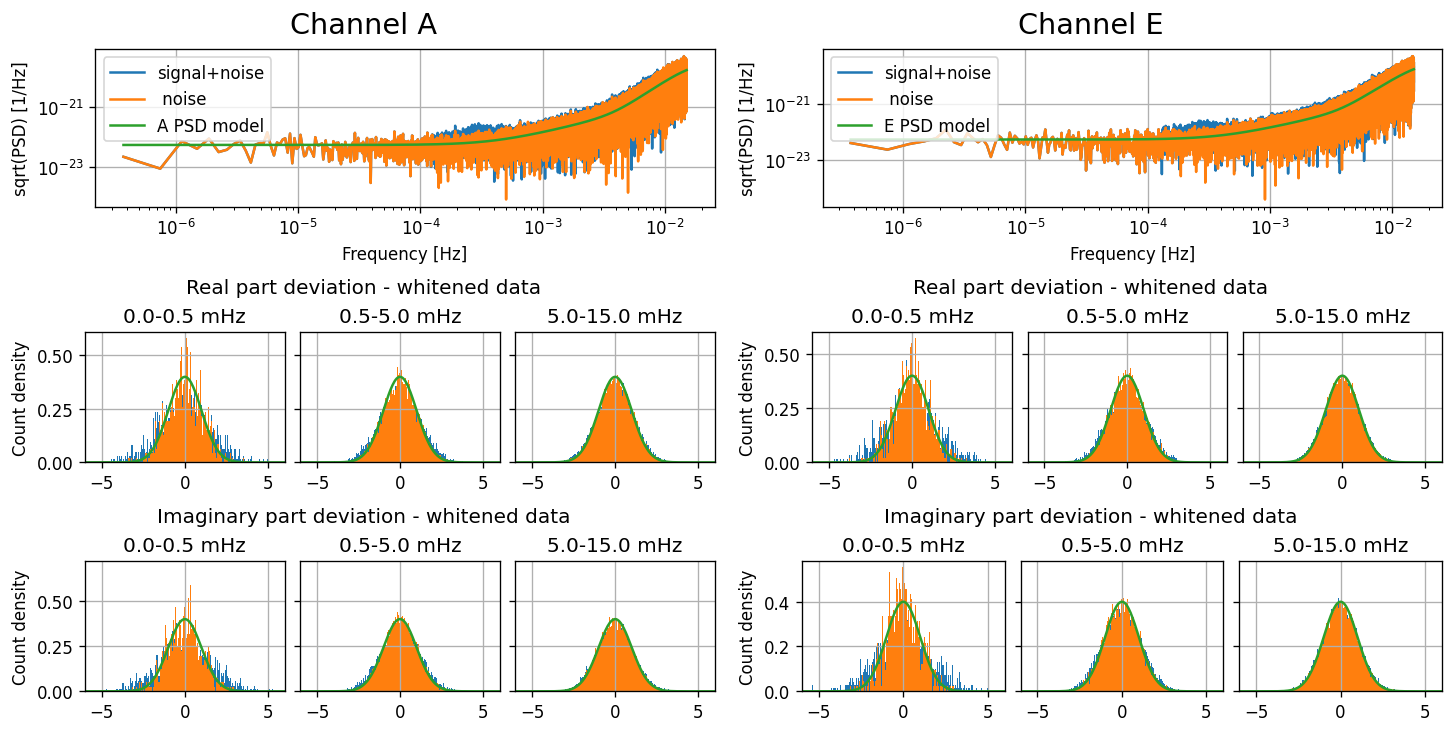

In [55]:
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_datan] ,
                                freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

## 4. Data imputation with short custom gaps 


### 4.1 Specify some short gaps (1000 samples) and generate gapped data
Based on the `n` data, we are going to add some gaps to this data realization.

We're going to start with 3 small gaps 20-sample 100-seconds long as in the original notebook to test the code.

In [56]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

In [57]:
# we already have time-domain data available, therefore we don't need to construct them starting from the noise spectrum
# we'll just use the LDC time-domain data to inject gaps
td_datans

rec.array([( 8899700., -1.41313308e-20,  8.71762442e-21,  6.29920699e-21),
           ( 8899705.,  1.10272254e-20,  7.69249335e-21,  1.77454024e-20),
           ( 8899710., -1.05706910e-20, -1.83141202e-20, -1.77660258e-20),
           ...,
           (11577585.,  1.16559187e-20,  4.90105682e-21, -5.21425230e-21),
           (11577590., -7.53217818e-21,  1.19384377e-21, -1.19772820e-22),
           (11577595.,  1.72154496e-20, -2.54999073e-22,  1.38797947e-20)],
          dtype=[('t', '<f8'), ('A', '<f8'), ('E', '<f8'), ('T', '<f8')])

In [58]:
SAVE = False
n_gaps = 3
gap_length = 1000

In [59]:
#construct gap mask
mask = np.ones(ndata)
ts = np.arange(ndata) * dt

maskinfo = construct_gap_mask(ndata,
                              n_gaps = n_gaps,
                              gap_length = gap_length,
                              verbose = True)
mask = maskinfo['mask']

Defined gaps:
  gap0 (371366:372366)
  gap1 (103724:104724)
  gap2 (72818:73818)


Text(0, 0.5, 'Random gap mask')

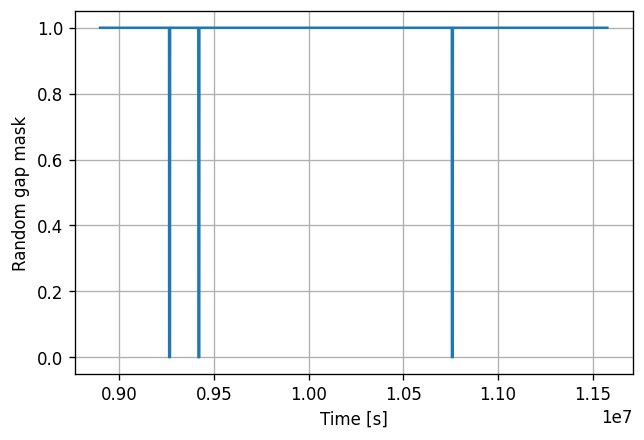

In [61]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(td_datan['t'],maskinfo['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Random gap mask')

In [62]:
td_datans_masked = td_datans.copy()

for names in td_datans.dtype.names[1:]:
    td_datans_masked[names] = mask * td_datans[names]

for i in range(len(maskinfo['starts'])):
    print('gap', i,
          ':\n\tsamples:', maskinfo['starts'][i],
          '< i <', maskinfo['ends'][i],
          '\n\tseconds:', ts[maskinfo['starts'][i]],
          '< t <', ts[maskinfo['ends'][i]])

gap 0 :
	samples: 371366 < i < 372366 
	seconds: 1856830.0 < t < 1861830.0
gap 1 :
	samples: 103724 < i < 104724 
	seconds: 518620.0 < t < 523620.0
gap 2 :
	samples: 72818 < i < 73818 
	seconds: 364090.0 < t < 369090.0


### 4.2 Function for viewing/comparing gap data

Given a set of gaps, together with various (eg gapped and ungapped) versions of the TD data, produces comparison plots for each channel around each gap.

In [63]:
# from lisabeta_fill_gaps import view_gaps
from bayesdawn.connect.fillgaps import view_gaps

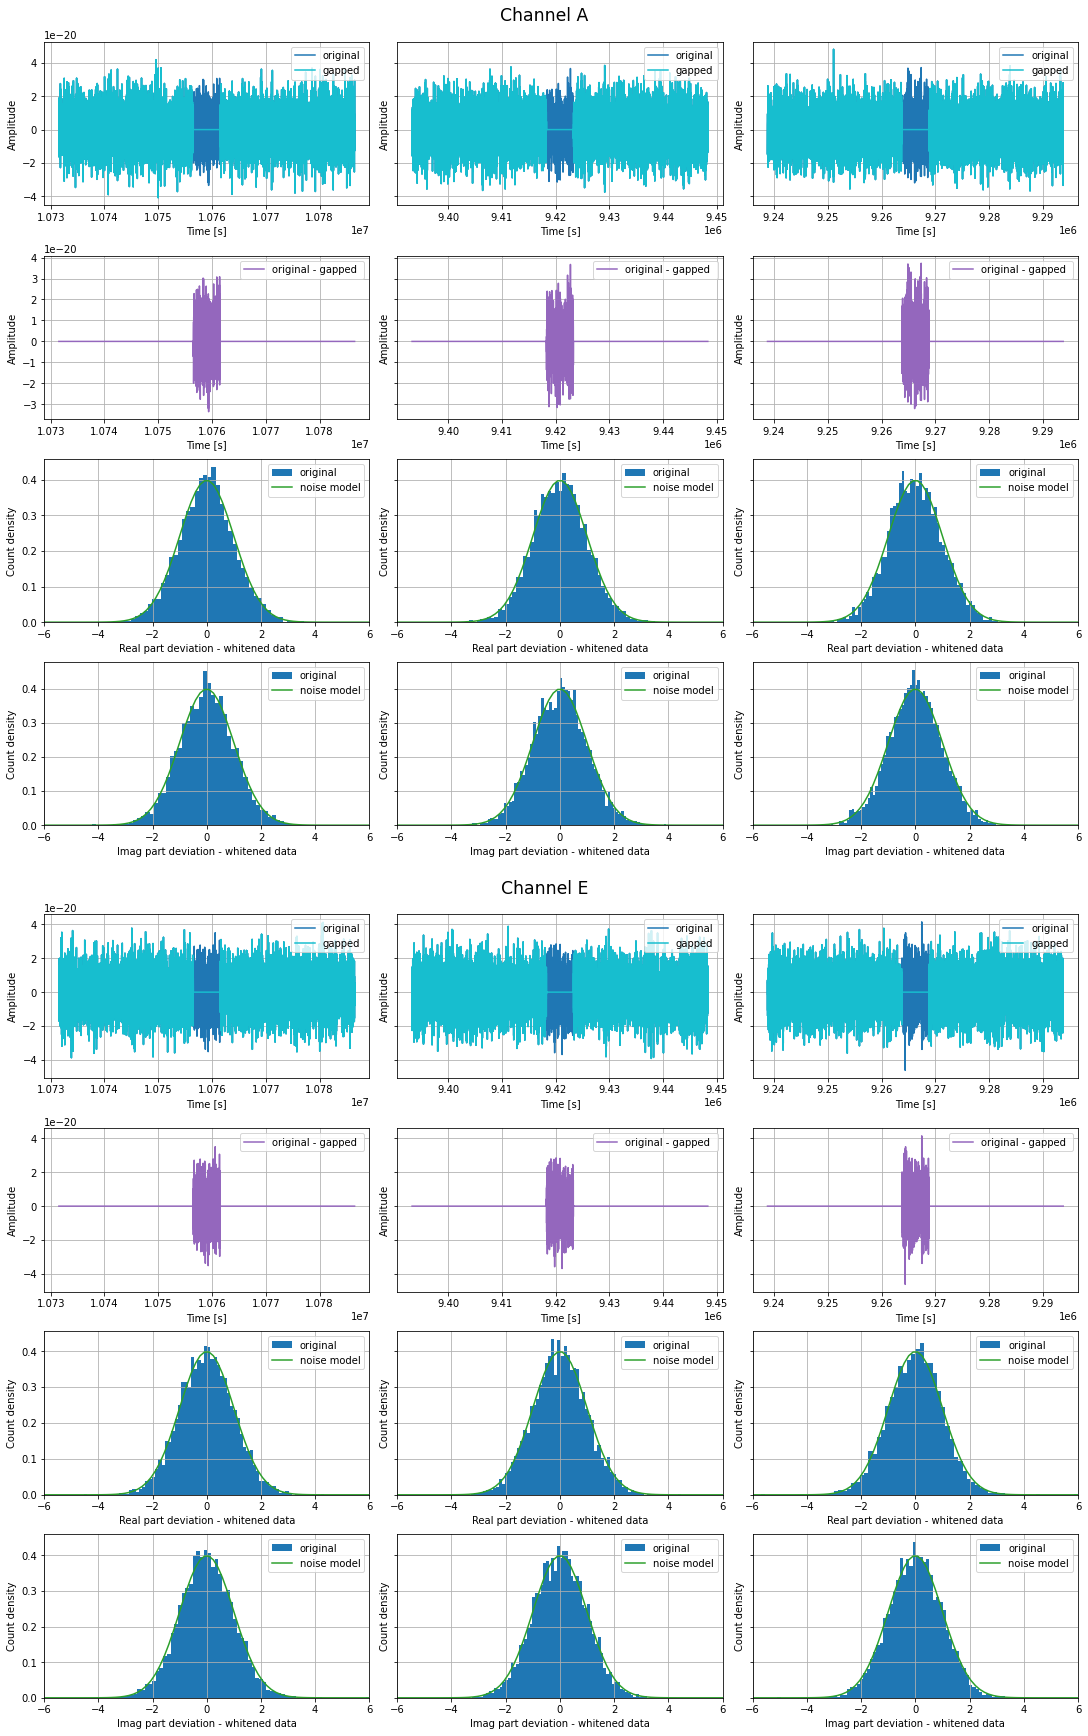

In [64]:
# view_gaps(ts,
#           [y, y_masked, yy, yyt],
#           gapstarts[:3], gapends[:3],
#           labels=['data', 'gapped', 'generated by func', 'transformed and reconstructed'])

view_gaps(ts = td_datans['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_datans_masked[names] for names in td_datans_masked.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'], nwing = 5000,
          labels=['original'])

### 4.3 Define a bayesdawn PSD model class built on the ldc PSD model

In [65]:
from bayesdawn.connect.fillgaps import LDCModelPSD
from bayesdawn import datamodel, psdmodel
import time

### 4.4 Apply imputation to noise data and compare spectra

#### Define some functions for concretely applying the bayesdawn gap impuation on  a set of FD data channels
- `create_imputation`: Make a set of bayesdawn imputation models from the LDC PSD-0 unequal arms noise model with a specified gap mask
- `update_imputation`: Perform the imputation on a set of FD residual data returning a revised version of the residual data, again in FD with re-drawn gap data.

In [66]:
from bayesdawn.connect.fillgaps import create_imputation, update_imputation

In [67]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
td_data_rec = np.rec.fromarrays([td_datans_masked['t']]+3*[np.zeros(len(td_datans_masked['t']))], 
                               names = td_datans_masked.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = maskinfo['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 20

fmin = 1 / t_obs * k

print(' `fmin` value is {:.2e}'.format(fmin))

# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(td_datans_masked, tdi, mask, noise_model = 'spritz')
    td_data_rec[tdi] = y_res
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = td_data_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin)
        td_data_rec[tdi] = y_res
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
    ax.legend(loc='best')
    ax.grid()

 `fmin` value is 7.47e-06
Computation of autocovariance + PSD took 7.780601739883423
Computation of autocovariance + PSD took 0.2657938003540039
Computation of autocovariance + PSD took 0.22276782989501953
Computation of autocovariance + PSD took 0.22550010681152344
Computation of autocovariance + PSD took 0.24958181381225586
Computation of autocovariance + PSD took 0.28171420097351074
Computation of autocovariance + PSD took 0.2722470760345459
Computation of autocovariance + PSD took 0.271838903427124
Computation of autocovariance + PSD took 0.2662510871887207
Computation of autocovariance + PSD took 0.2501640319824219
Computation of autocovariance + PSD took 0.24451708793640137


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Imputation for combination A took 31.318697929382324
Computation of autocovariance + PSD took 7.203248977661133
Computation of autocovariance + PSD took 0.2429509162902832
Computation of autocovariance + PSD took 0.24190998077392578
Computation of autocovariance + PSD took 0.25501203536987305
Computation of autocovariance + PSD took 0.24968385696411133
Computation of autocovariance + PSD took 0.25012731552124023
Computation of autocovariance + PSD took 0.24111008644104004
Computation of autocovariance + PSD took 0.2555580139160156
Computation of autocovariance + PSD took 0.2459559440612793
Computation of autocovariance + PSD took 0.24909591674804688
Computation of autocovariance + PSD took 0.23649382591247559


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Imputation for combination E took 31.225483179092407


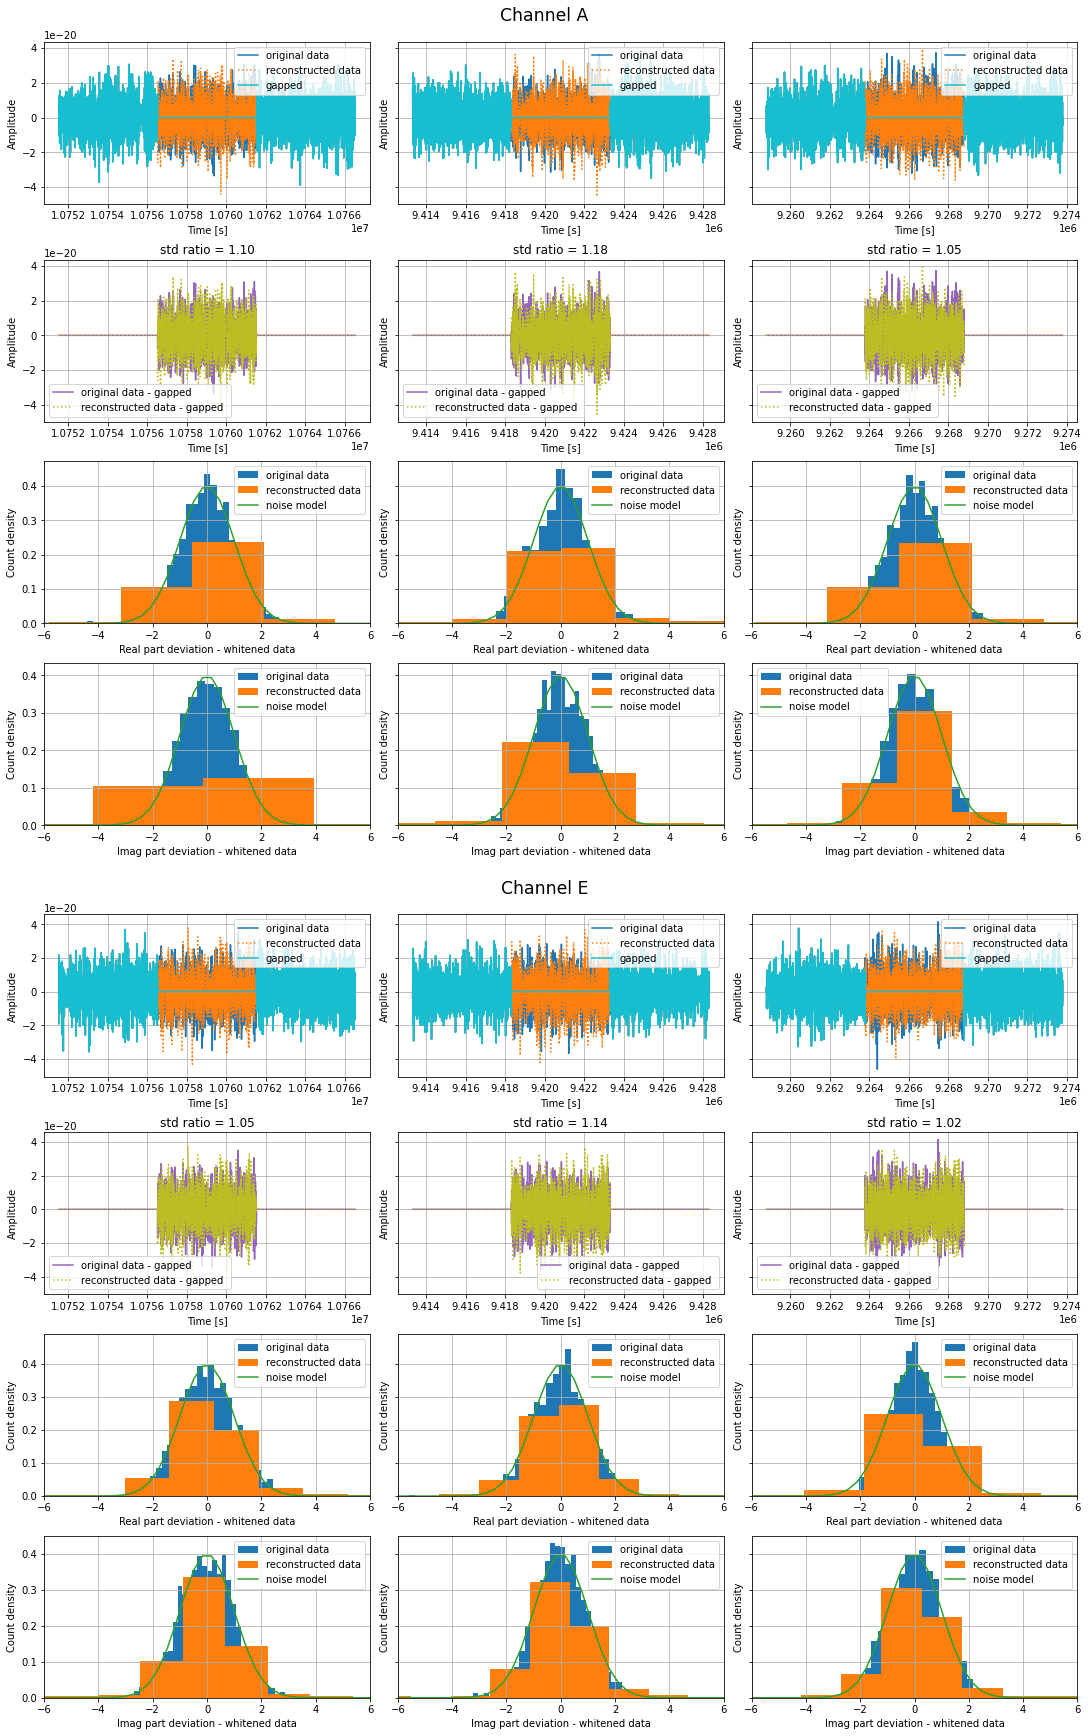

In [73]:
view_gaps(ts = td_datans['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]], 
                [td_data_rec[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_datans_masked[names] for names in td_datans.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'], nwing = 1000,
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = SAVE)

In [74]:
# generate fft and psd from reconstructed data
fdatan_rec, psddata_rec, _ = generate_freq_data(td_data_rec, split = True) 

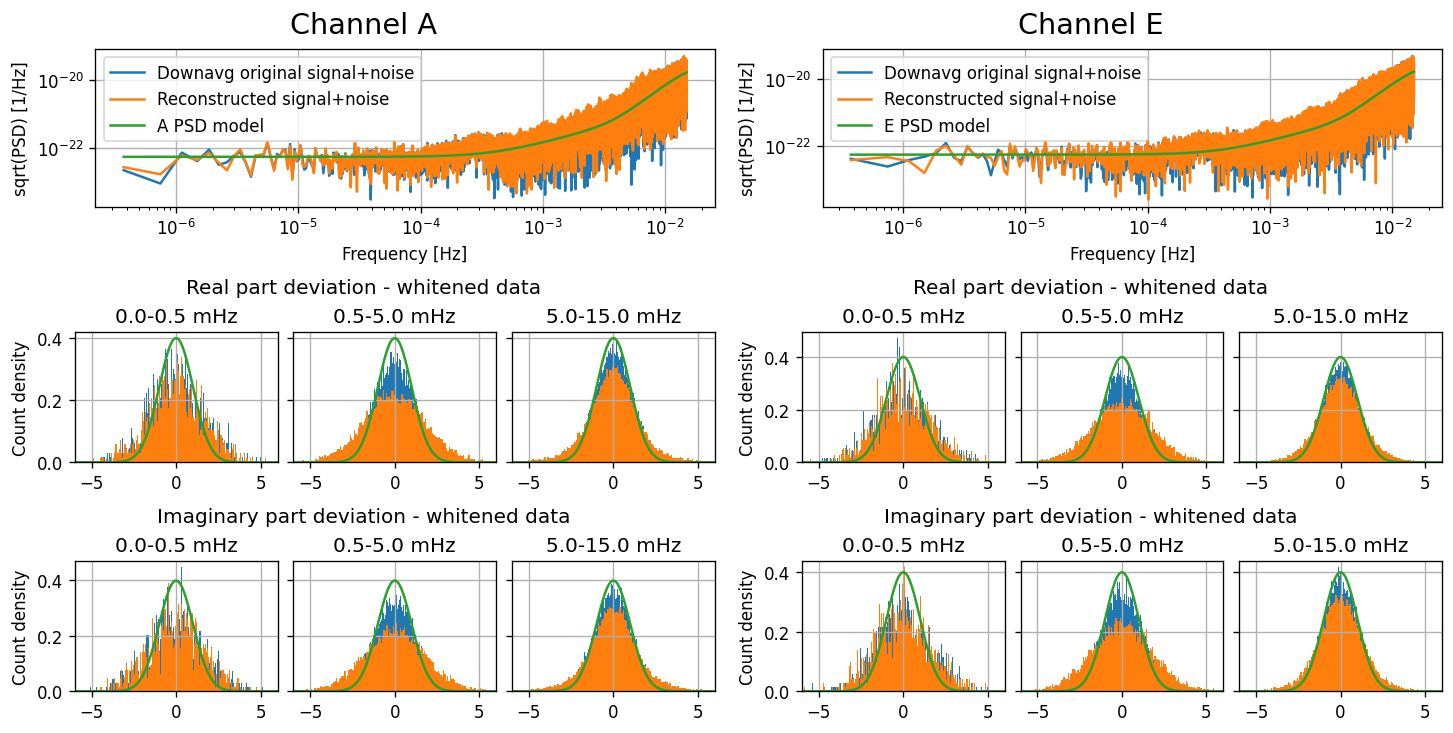

In [75]:
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_data_rec],#,data_masked], 
                                  freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Downavg original signal+noise', 'Reconstructed signal+noise'],#, 'gapped data'], 
                                save = SAVE)

## 5. Data imputation with Spritz data 
Do this again with the Spritz noise data
### 5.1 Get Spritz gaps data.

In [76]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import get_ldc_gap_mask

In [79]:
td_datans

rec.array([( 8899700., -1.41313308e-20,  8.71762442e-21,  6.29920699e-21),
           ( 8899705.,  1.10272254e-20,  7.69249335e-21,  1.77454024e-20),
           ( 8899710., -1.05706910e-20, -1.83141202e-20, -1.77660258e-20),
           ...,
           (11577585.,  1.16559187e-20,  4.90105682e-21, -5.21425230e-21),
           (11577590., -7.53217818e-21,  1.19384377e-21, -1.19772820e-22),
           (11577595.,  1.72154496e-20, -2.54999073e-22,  1.38797947e-20)],
          dtype=[('t', '<f8'), ('A', '<f8'), ('E', '<f8'), ('T', '<f8')])

In [81]:
mask = np.ones(td_datag.shape[0])
ndata = td_datag.shape[0]

spritzgaps = get_ldc_gap_mask(td_datag, mode='index')
gapstarts,gapends= np.vsplit(spritzgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((2))[k]:gapends.reshape((2))[k]]=0

spritzmask = {'mask': mask,
              'starts': gapstarts.reshape((2)),
              'ends': gapends.reshape((2))}

figname = 'figures/nodownavg_spritzgaps'

Text(0, 0.5, 'Spritz gap mask')

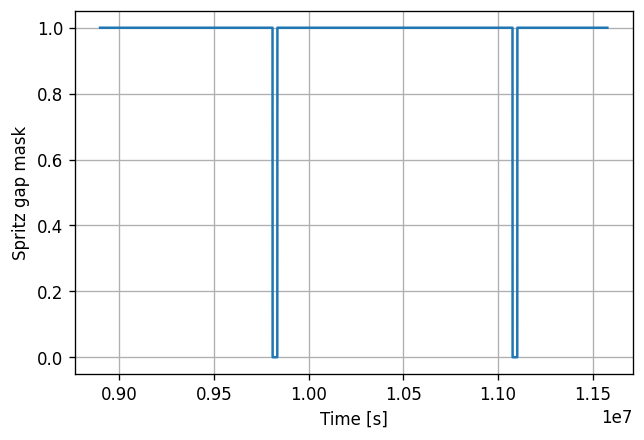

In [83]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(td_datag['t'],spritzmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

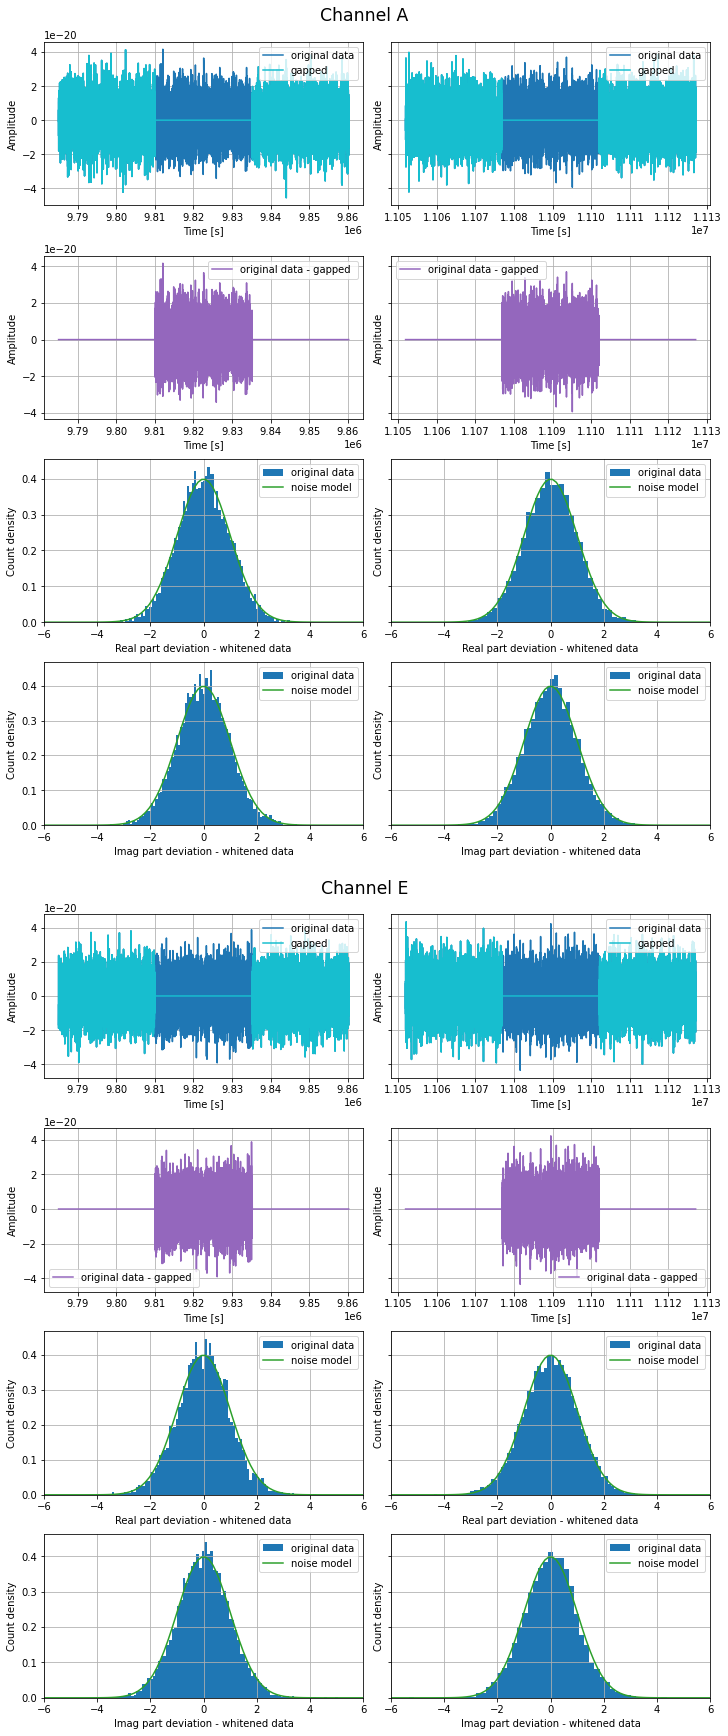

In [97]:
view_gaps(ts = td_datan['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_datag[names] for names in td_datag.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 5000, histogram=True)

### 5.3 Apply imputation to noise data and compare spectra

In [94]:
from bayesdawn.connect.fillgaps import create_imputation, update_imputation

In [100]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
td_data_rec = np.rec.fromarrays([td_datag['t']]+3*[np.zeros(len(td_datag['t']))], 
                               names = td_datag.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 20

fmin = 1 / t_obs * k

print(' `fmin` value is {:.2e}'.format(fmin))

# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(td_datag, tdi, mask, noise_model = 'spritz')
    td_data_rec[tdi] = y_res
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = td_data_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin)
        td_data_rec[tdi] = y_res
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
    ax.legend(loc='best')
    ax.grid()

 `fmin` value is 7.47e-06


/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py:340: UserWarning: The maximum size of gap + conditional is high.


Computation of autocovariance + PSD took 8.223613023757935
Computation of autocovariance + PSD took 0.23061299324035645
Computation of autocovariance + PSD took 0.22703790664672852
Computation of autocovariance + PSD took 0.22965192794799805
Computation of autocovariance + PSD took 0.25136709213256836
Computation of autocovariance + PSD took 0.22575020790100098
Computation of autocovariance + PSD took 0.2362060546875
Computation of autocovariance + PSD took 0.23641324043273926
Computation of autocovariance + PSD took 0.22734594345092773
Computation of autocovariance + PSD took 0.24083614349365234


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computation of autocovariance + PSD took 0.22715425491333008
Imputation for combination A took 14.552466869354248
Computation of autocovariance + PSD took 6.223504304885864
Computation of autocovariance + PSD took 0.2205677032470703
Computation of autocovariance + PSD took 0.22554492950439453
Computation of autocovariance + PSD took 0.22836518287658691
Computation of autocovariance + PSD took 0.22099804878234863
Computation of autocovariance + PSD took 0.2235429286956787
Computation of autocovariance + PSD took 0.21858811378479004
Computation of autocovariance + PSD took 0.22705602645874023
Computation of autocovariance + PSD took 0.2287459373474121
Computation of autocovariance + PSD took 0.23176097869873047


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computation of autocovariance + PSD took 0.22718381881713867
Imputation for combination E took 12.333118200302124


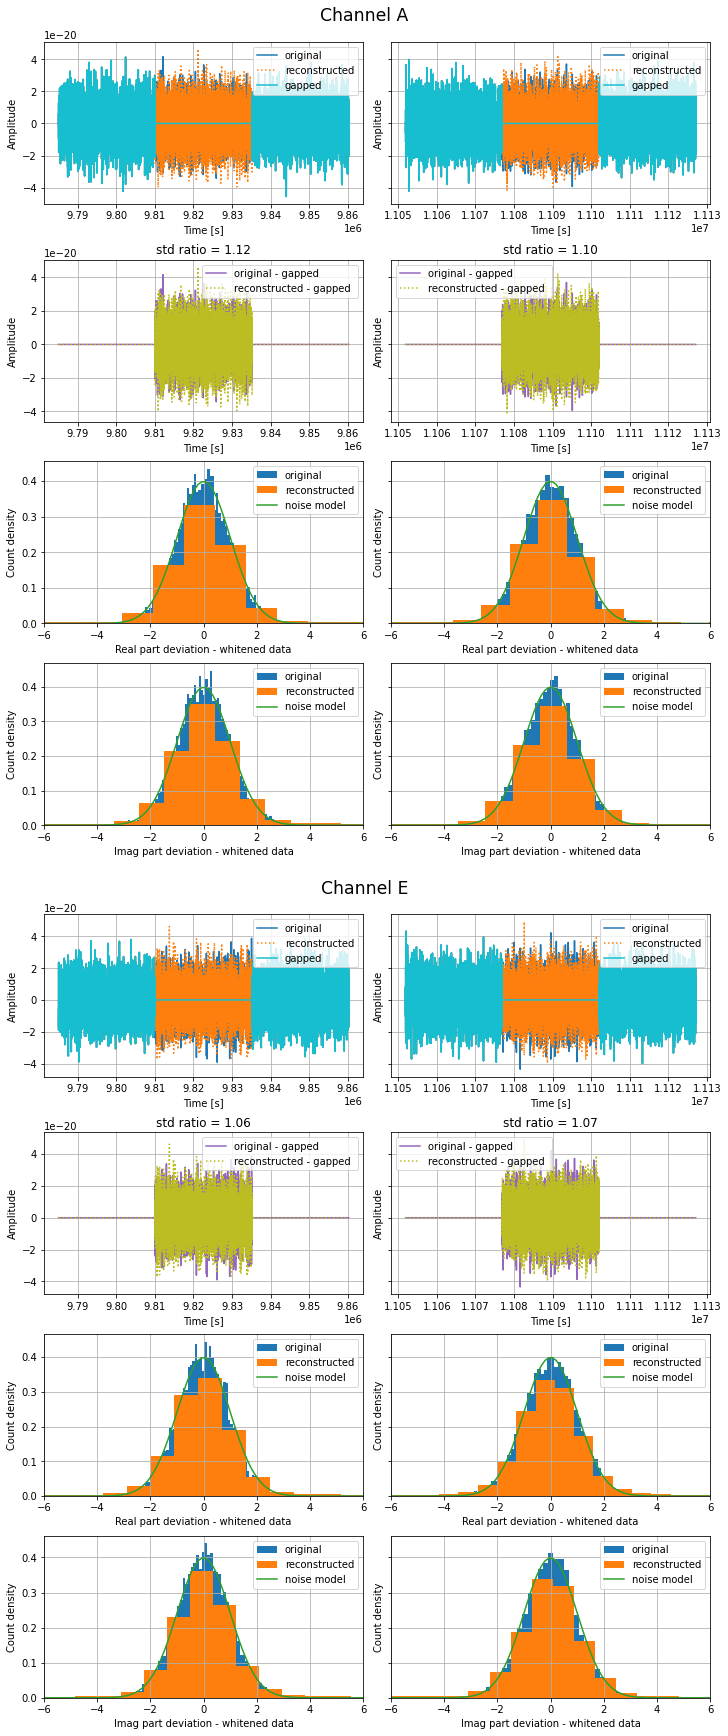

In [101]:
view_gaps(ts = td_datag['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]], 
                [td_data_rec[names] for names in td_data_rec.dtype.names[1:]]],
          yg = [td_datag[names] for names in td_datag.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'], nwing = 5000,
          labels=['original', 'reconstructed', 'gapped data'],
          save = SAVE)

In [102]:
# generate fft and psd from reconstructed data
fdatan_rec, psddata_rec, _ = generate_freq_data(td_data_rec, split = True) 

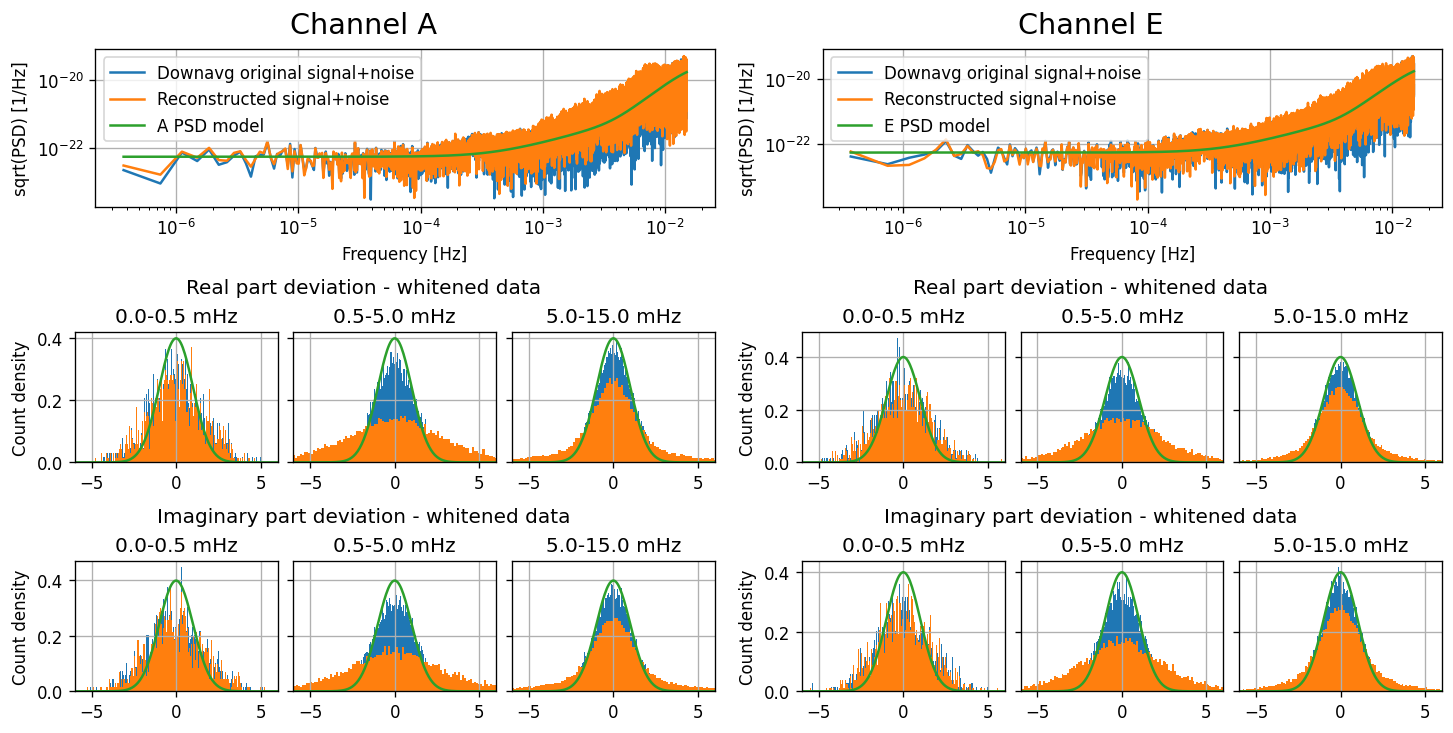

In [103]:
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_data_rec],#,data_masked], 
                                  freq_bands=[5e-4, 5e-3],
                                fmax = 1.5e-2,
                               labels = ['Downavg original signal+noise', 'Reconstructed signal+noise'],#, 'gapped data'], 
                                save = SAVE)